SageMaker imports and setup 

In [ ]:
! pip install tensorrt

In [79]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar
import time
import keras_cv

# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Downloading 

In [2]:
dm = tfds.download.DownloadManager(download_dir='/home/ec2-user/SageMaker')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# initalise the splits we are interested in
SPLITS = ['train', 'val']
# get splits resource name
SPLIT_FILE = [SPLIT_FILENAMES[split] for split in SPLITS]

# maps dataset to split tar & json files
splitDownloads = {}

In [3]:
# downloading the tar file containing validation images

for count, split in enumerate(SPLITS):
  # download image tar file
  splitDownloads[f'{split}_img'] =  tfds.download.Resource(
            url=f'{URL}/{SPLIT_FILE[count]}.tar.gz',
            extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
        )
  # download json annotation file
  splitDownloads[f'{split}_json'] = f'{URL}/{SPLIT_FILE[count]}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)

{'train_img': <tensorflow_datasets.core.download.resource.Resource object at 0x7fd867c2b4c0>, 'train_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/train.json.tar.gz', 'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x7fd82070db10>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [4]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [29]:
# List containing the animals that user want to see/train on
SPECIES_TO_RETRIEVE =  sorted([
                    'pavo_cristatus', #peacock
                    'capra_hircus',   #goat
                    'dama_dama', #european fallow deer
                    'dromaius_novaehollandiae', # emu
                    'cavia_aperea', # brazilian guinea pig
                    'oryctolagus_cuniculus', # european rabbit
                    'melopsittacus_undulatus', # budgerigar
                    'ara_ararauna', # blue and yellow macaw
                    'vicugna_vicugna', # vicuña
                    'lama_guanicoe', # Guanaco
                    'equus_asinus', # donkey
                    'gallus_gallus', # chicken
                    'phasianus_colchicus', # ring-necked pheasant
                    'wallabia_bicolor', # Golden swamp wallaby
                    'testudo_hermanni', # Hermann's tortoise
                    'equus_caballus', # shetland pony
                    'trachemys_scripta', # red-eared slider
                    'procyon_lotor', # north american raccoon
                    'aix_galericulata', # mandarin duck
                    'iguana_iguana', # green iguana
                    'pantherophis_guttatus', # corn snake
                    'struthio_camelus', # common ostrich
                    'bubo_scandiacus', # snowy owl
                    'cygnus_atratus', # black swan
                    'panthera_leo', # lion
                    'bubo_bubo', # Eurasian eagle-owl
                    # 'ciconia_ciconia', # white stork
                    # 'pogona_barbata', # Eastern bearded dragon
                    # 'ara_macao', # south american scarlet macaww
                    # 'ovis_aries', # mouflon
                    # 'nasua_nasua', # south-american coati
                    # 'aix_sponsa', #  wood duck
                    # 'anser_anser', # greylag goose
                    # 'cairina_moschata', # muscovy duck
                    # 'hydrochoerus_hydrochaeris', # capybara
                    # 'dacelo_novaeguineae', # kookaburra
                    # 'cyprinus_rubrofuscus', # koi fish
                    # 'callithrix_penicillata', # black-tufted marmoset
                    # 'lutra_lutra', # otter
                    # 'haliaeetus_leucocephalus', # bald eagle
                    # 'numida_meleagris', # helmeted guineafowl
                    # 'mustela_frenata', # long-tailed weasel
                    # 'anas_platyrhynchos', # mallard duck
                    # 'boa_constrictor', # boa constrictor
                    # 'giraffa_camelopardalis', # giraffe
                    # 'alligator_mississippiensis', # mississippi alligator
                    # 'panthera_onca', # jaguar
                    # 'panthera_pardus', # leopard
                    # 'parabuteo_unicinctus', # desert Hawk
                    # 'puma_concolor', # cougar
                     ])


SPECIES_TO_RETRIEVE = [' '.join(s.split('_')) for s in SPECIES_TO_RETRIEVE]

In [30]:
# replace ' ' with '_' in a string
def format(label: str):
      return label.lower().replace(' ', '_')


# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, imageId, inatJson):

      if 'annotations' in inatJson:
        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == imageId

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

In [80]:
# establish paths to loaded validation dataset
split = SPLITS[1]

# get paths for image archive and to annotation json file
valImagesArchive = outputPaths[f'{split}_img']
jsonFile = os.path.join(outputPaths[f'{split}_json'],f'{SPLIT_FILENAMES[split]}.json')
trainImagesArchive = outputPaths[f'{SPLITS[0]}_img']

print(valImagesArchive)
print(trainImagesArchive) 

HOME_PATH = '/home/ec2-user/SageMaker'
EXTRACT_PATH = f'{HOME_PATH}/dataset'

In [32]:
# load json annotation
with epath.Path(jsonFile).open('r') as f:
      valInatJson = json.load(f)

In [37]:
valAnnotatedFiles = {}   # maps unique image id to metadata species annotation
SPECIES_TO_RETRIEVE = [format(i) for i in SPECIES_TO_RETRIEVE]

for idx, image  in enumerate(valInatJson['images']):
  category, superCategory, imageDirectory = getAnnotation(idx, image['id'], valInatJson)
# Checking if the species is a vertebrate and checking if current image is a species of animal we are interested in retrieving
  if (superCategory in vertebrates) and (category in SPECIES_TO_RETRIEVE):
    field = os.path.basename(image['file_name']).split('.')[0]

    valAnnotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }


In [53]:
# contains image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(valImagesArchive, 'r')

except IOError as e:
  print(e)

else:
  for id,value in valAnnotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  # extract all images of species we are interested in
  t.extractall(EXTRACT_PATH)

In [39]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(trainImagesArchive, 'r')

except IOError as e:
  print(e)

else:
  t.extractall(EXTRACT_PATH)

In [54]:
# deleting classes we are not training
import os,sys
import shutil

# get directory paths of species we want to train by getting all directory names
# from our extracted validation dataset. Because we didn't download the whole validation dataset
speciesDir = []

for id,value in valAnnotatedFiles.items():
    if value['imagedirectory'] not in speciesDir:
      speciesDir.append(value['imagedirectory'])

print(speciesDir) 

['04506_Animalia_Chordata_Aves_Psittaciformes_Psittacidae_Ara_ararauna', '04644_Animalia_Chordata_Mammalia_Artiodactyla_Camelidae_Lama_guanicoe', '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo', '04548_Animalia_Chordata_Aves_Strigiformes_Strigidae_Bubo_scandiacus', '03637_Animalia_Chordata_Aves_Galliformes_Phasianidae_Phasianus_colchicus', '04796_Animalia_Chordata_Mammalia_Rodentia_Caviidae_Cavia_aperea', '03239_Animalia_Chordata_Aves_Anseriformes_Anatidae_Cygnus_atratus', '03632_Animalia_Chordata_Aves_Galliformes_Phasianidae_Gallus_gallus', '04719_Animalia_Chordata_Mammalia_Carnivora_Procyonidae_Procyon_lotor', '04769_Animalia_Chordata_Mammalia_Perissodactyla_Equidae_Equus_caballus', '03330_Animalia_Chordata_Aves_Casuariiformes_Casuariidae_Dromaius_novaehollandiae', '03635_Animalia_Chordata_Aves_Galliformes_Phasianidae_Pavo_cristatus', '05016_Animalia_Chordata_Reptilia_Squamata_Iguanidae_Iguana_iguana', '04652_Animalia_Chordata_Mammalia_Artiodactyla_Cervidae_Dama_dam

In [ ]:
# get train_mini extracted dataset path
path = f'{EXTRACT_PATH}/train'
# get list of directories in train_mini
dirs = os.listdir( path )
for d in dirs:
  # if train_mini directory's name does not match an existing directory in our validation dataset
  if d not in speciesDir:
    try:
      # delete species directory
      shutil.rmtree(os.path.join(path, d))
    except:
      print(f'error with directory {os.path.join(path, d)}')

In [55]:
# get train_mini extracted dataset path
path = f'{EXTRACT_PATH}/val'
# get list of directories in val
dirs = os.listdir( path )
for d in dirs:
  # if val directory's name does not match an existing directory in our annotated list 
  if d not in speciesDir:
    try:
      # delete species directory
      shutil.rmtree(os.path.join(path, d))
    except:
      print(f'error with directory {os.path.join(path, d)}')

In [42]:
imgHeight = 200
imgWidth = 200

In [46]:
print(SPECIES_TO_RETRIEVE)

['aix_galericulata', 'ara_ararauna', 'bubo_bubo', 'bubo_scandiacus', 'capra_hircus', 'cavia_aperea', 'cygnus_atratus', 'dama_dama', 'dromaius_novaehollandiae', 'equus_asinus', 'equus_caballus', 'gallus_gallus', 'iguana_iguana', 'lama_guanicoe', 'melopsittacus_undulatus', 'oryctolagus_cuniculus', 'panthera_leo', 'pantherophis_guttatus', 'pavo_cristatus', 'phasianus_colchicus', 'procyon_lotor', 'struthio_camelus', 'testudo_hermanni', 'trachemys_scripta', 'vicugna_vicugna', 'wallabia_bicolor']


In [56]:
# image resize copy dataset

# rename all folders to match class names of the validation dataset
path = f'{EXTRACT_PATH}/val'
dirs = os.listdir(path)

for folder in dirs:
    # rename species folder
  if len(folder.split('_')) > 3:
      os.rename(f"{path}/{folder}", f"{path}/{('_'.join(folder.split('_')[6::])).lower()}")

      # get path of each image in class folder
      newPath = f"{path}/{('_'.join(folder.split('_')[6::])).lower()}"
  else:
      newPath = f"{path}/{folder}"
        
  imageDir = os.listdir(newPath)

  for item in imageDir:
    itemPath = f"{newPath}/{item}"
    try:
        im = Image.open(itemPath)
        width, height = im.size
        minDimension = min(width, height)
        # left(x), upper(y), right(x), lower(y)
        imgMidArea = ((width - minDimension) // 2,
                        (height - minDimension) // 2,
                        ((width - minDimension) // 2) + minDimension,
                          ((height - minDimension) // 2) + minDimension)
        imgCropped = im.crop(imgMidArea)

        # resize square cropped images to 200x200px
        imResize = imgCropped.resize((imgWidth,imgHeight))

        imResize.save(itemPath,'JPEG', quality=90)
    except Exception as e:
        print(e)


In [57]:
# image resize copy dataset

# rename all folders to match class names of the validation dataset
path = f'{EXTRACT_PATH}/train'
dirs = os.listdir(path)

for folder in dirs:
    # rename species folder
  if len(folder.split('_')) > 3:
      os.rename(f"{path}/{folder}", f"{path}/{('_'.join(folder.split('_')[6::])).lower()}")

      # get path of each image in class folder
      newPath = f"{path}/{('_'.join(folder.split('_')[6::])).lower()}"
  else:
      newPath = f"{path}/{folder}"
        
  imageDir = os.listdir(newPath)

  for item in imageDir:
    itemPath = f"{newPath}/{item}"
    try:
        im = Image.open(itemPath)
        width, height = im.size
        minDimension = min(width, height)
        # left(x), upper(y), right(x), lower(y)
        imgMidArea = ((width - minDimension) // 2,
                        (height - minDimension) // 2,
                        ((width - minDimension) // 2) + minDimension,
                          ((height - minDimension) // 2) + minDimension)
        imgCropped = im.crop(imgMidArea)

        # resize square cropped images to 200x200px
        imResize = imgCropped.resize((imgWidth,imgHeight))

        imResize.save(itemPath,'JPEG', quality=90)
    except Exception as e:
        print(e)


Quick Check 

In [81]:
import pathlib
dataDir = pathlib.Path(f'{EXTRACT_PATH}/train').with_suffix('')      # directory that stores the training data

# image count
imageCount = len(list(dataDir.glob('*/*.jpg')))
print(imageCount)

7368


Creating the dataset

In [82]:
batchSize = 32

In [83]:
# Creating the training dataset
trainDs = tf.keras.utils.image_dataset_from_directory(
  dataDir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

Found 7368 files belonging to 26 classes.


In [84]:
# Creating the training dataset
valDs = tf.keras.utils.image_dataset_from_directory(
  f'{EXTRACT_PATH}/val',
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

Found 260 files belonging to 26 classes.


In [85]:
# Identifying class names that model has to train for. These the species the user selected to train on.
classNames = trainDs.class_names
print(classNames)

['aix_galericulata', 'ara_ararauna', 'bubo_bubo', 'bubo_scandiacus', 'capra_hircus', 'cavia_aperea', 'cygnus_atratus', 'dama_dama', 'dromaius_novaehollandiae', 'equus_asinus', 'equus_caballus', 'gallus_gallus', 'iguana_iguana', 'lama_guanicoe', 'melopsittacus_undulatus', 'oryctolagus_cuniculus', 'panthera_leo', 'pantherophis_guttatus', 'pavo_cristatus', 'phasianus_colchicus', 'procyon_lotor', 'struthio_camelus', 'testudo_hermanni', 'trachemys_scripta', 'vicugna_vicugna', 'wallabia_bicolor']


In [86]:
for image_batch, labels_batch in trainDs:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [87]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

trainDs = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valDs = valDs.cache().prefetch(buffer_size=AUTOTUNE)

Training with ResNet50

In [105]:
from tensorflow.keras.applications import ResNet50

numClasses = len(classNames)
resnet50Model = ResNet50(weights='imagenet', include_top=False, input_shape=(imgHeight, imgWidth, 3))

# Freeze the pretrained weights
resnet50Model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(imgHeight, imgWidth, 3))
x = resnet50Model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(numClasses)(x)
model = keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 2s 0us/step


In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 26)                53274     
                                                                 
Total params: 23640986 (90.18 MB)
Trainable params: 53274 (208.10 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [107]:
# using 10 epochs of size 32 and with model.fit method

epochs=10
history = model.fit(
  trainDs,
  validation_data=valDs,
  epochs=epochs
)

Epoch 1/10
231/231 [==============================] - 98s 378ms/step - loss: 1.5506 - accuracy: 0.5559 - val_loss: 1.2050 - val_accuracy: 0.6423
Epoch 2/10
231/231 [==============================] - 83s 360ms/step - loss: 0.9212 - accuracy: 0.7313 - val_loss: 1.0936 - val_accuracy: 0.6385
Epoch 3/10
231/231 [==============================] - 83s 358ms/step - loss: 0.7357 - accuracy: 0.7820 - val_loss: 1.1077 - val_accuracy: 0.6269
Epoch 4/10
231/231 [==============================] - 84s 362ms/step - loss: 0.6124 - accuracy: 0.8176 - val_loss: 1.0455 - val_accuracy: 0.6769
Epoch 5/10
231/231 [==============================] - 83s 361ms/step - loss: 0.5249 - accuracy: 0.8546 - val_loss: 1.0887 - val_accuracy: 0.6731
Epoch 6/10
231/231 [==============================] - 83s 361ms/step - loss: 0.4501 - accuracy: 0.8780 - val_loss: 1.0852 - val_accuracy: 0.6577
Epoch 7/10
231/231 [==============================] - 84s 362ms/step - loss: 0.3900 - accuracy: 0.9012 - val_loss: 1.1064 - val_ac

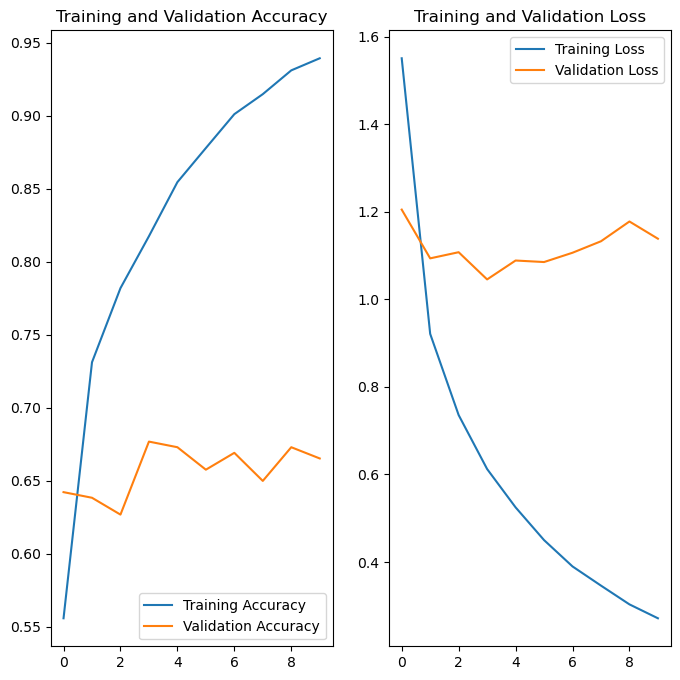

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training with an visually augmented dataset

In [88]:
IMAGE_SIZE = (imgWidth, imgHeight)
NUM_CLASSES = len(classNames)
BATCH_SIZE = batchSize

In [89]:
randAugment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)

def toDict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def visualiseDs(ds):
  plt.figure(figsize=(10, 10))
  for images, labels in ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(classNames[labels[i]])
      plt.axis("off")
        
def applyRandAugment(inputs):
    inputs["images"] = randAugment(inputs["images"])
    return inputs

def visualizeDataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
    
def preprocessForModel(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

def getModel():
    model = keras_cv.models.ImageClassifier.from_preset(
        "efficientnetv2_s", num_classes=NUM_CLASSES
    )
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=keras.optimizers.SGD(momentum=0.9),
        metrics=["accuracy"],
    )
    return model

Dataset before augmentation


2024-07-15 16:41:12.678968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


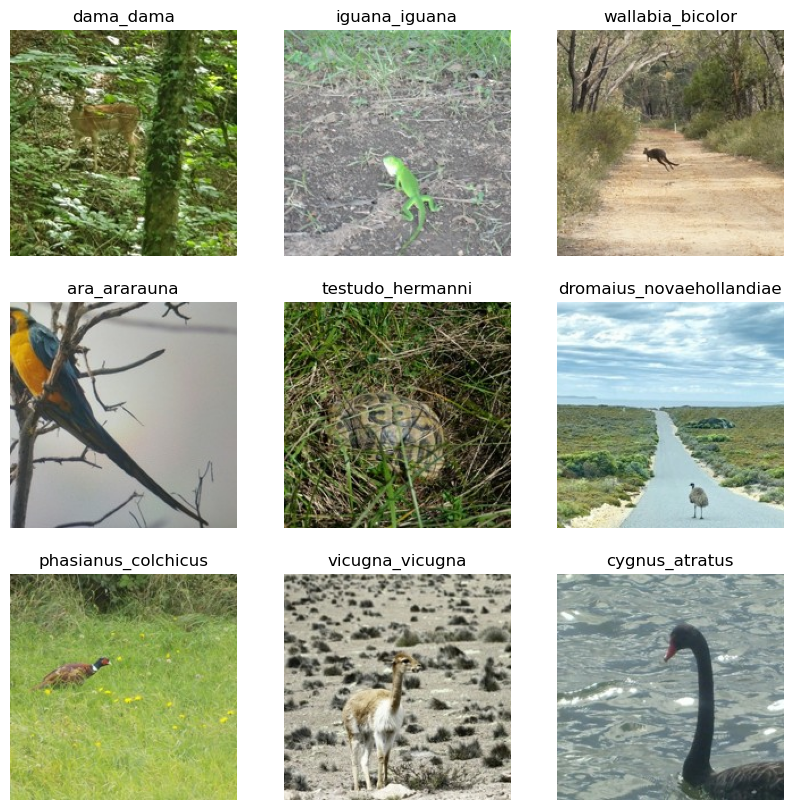

In [90]:
# visualising normal training dataset 

print("Dataset before augmentation") 
visualiseDs(trainDs)

In [91]:
# Apply randaugment to training dataset 
trainDs.shuffle(10*BATCH_SIZE).map(toDict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
augDs = trainDs.map((lambda x, y: (randAugment(x), y)))

Dataset after Randaugment


2024-07-15 16:41:16.738062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


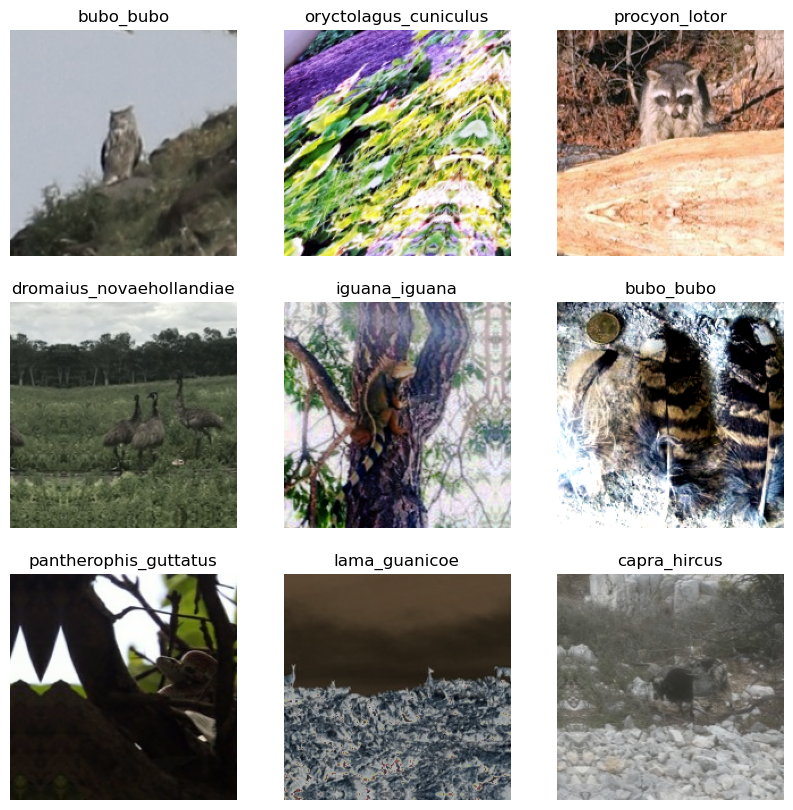

In [92]:
# visualise augmented dataset 
print("Dataset after Randaugment")
visualiseDs(augDs) 

In [93]:
# apply cutmix and mixup augmentation to already augmented dataset 

cutMix = keras_cv.layers.CutMix()
mixUp = keras_cv.layers.MixUp()
augDs = augDs.map(toDict)
augDs = augDs.map(cutMix)
augDs = augDs.map(mixUp)

2024-07-15 16:41:19.184166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


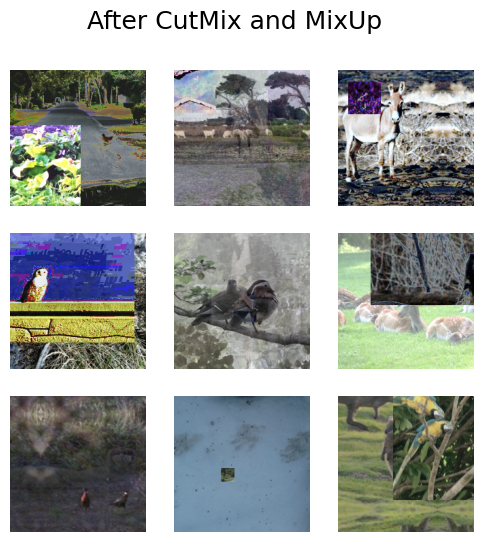

In [94]:
# visualise augmented dataset with cutmix and mixup 

visualizeDataset(augDs, title="After CutMix and MixUp")

In [95]:
# prepare validation dataset 

augValDs = valDs.map(toDict) 
augDs = augDs.map(preprocessForModel)
augValDs = augValDs.map(preprocessForModel, num_parallel_calls=AUTOTUNE)

In [96]:
input_shape = IMAGE_SIZE + (3,)

model = getModel()
model.summary()

Model: "image_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficient_net_v2_backbone   (None, None, None, 1280   20331360  
 (EfficientNetV2Backbone)    )                                   
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 predictions (Dense)         (None, 26)                33306     
                                                                 
Total params: 20364666 (77.69 MB)
Trainable params: 20210794 (77.10 MB)
Non-trainable params: 153872 (601.06 KB)
_________________________________________________________________


In [ ]:
epochs = 10
history = model.fit(
    augDs,
    epochs=epochs,
    validation_data=augValDs,
)

Epoch 1/10
231/231 [==============================] - 394s 2s/step - loss: 3.3666 - accuracy: 0.0379 - val_loss: 3.5099 - val_accuracy: 0.0538
Epoch 2/10
231/231 [==============================] - 334s 1s/step - loss: 3.3150 - accuracy: 0.0409 - val_loss: 3.3319 - val_accuracy: 0.0423
Epoch 3/10
231/231 [==============================] - 331s 1s/step - loss: 3.2864 - accuracy: 0.0436 - val_loss: 3.2737 - val_accuracy: 0.0692
Epoch 4/10
231/231 [==============================] - 330s 1s/step - loss: 3.2685 - accuracy: 0.0391 - val_loss: 3.2513 - val_accuracy: 0.0577
Epoch 5/10
231/231 [==============================] - 330s 1s/step - loss: 3.2629 - accuracy: 0.0463 - val_loss: 3.2560 - val_accuracy: 0.0538
Epoch 6/10
231/231 [==============================] - 329s 1s/step - loss: 3.2592 - accuracy: 0.0448 - val_loss: 3.2322 - val_accuracy: 0.0538
Epoch 7/10
231/231 [==============================] - 329s 1s/step - loss: 3.2546 - accuracy: 0.0437 - val_loss: 3.2323 - val_accuracy: 0.0692

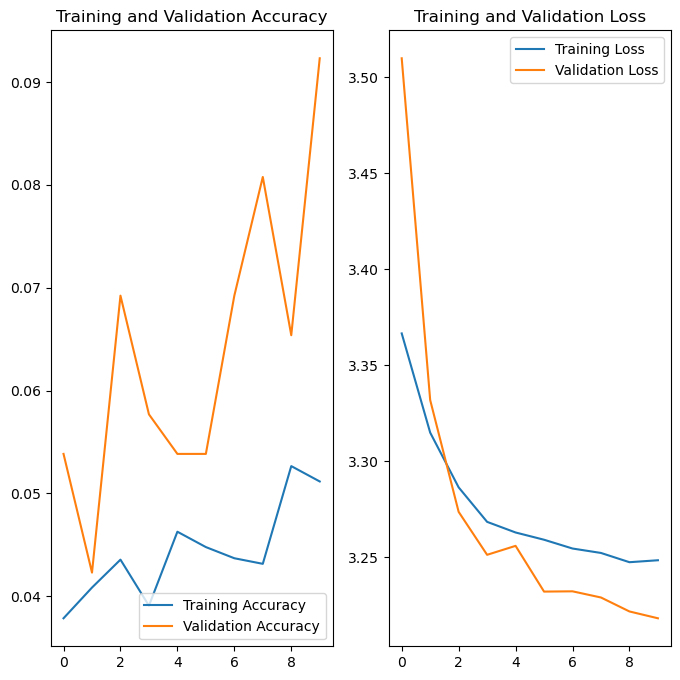

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()